In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set(style='whitegrid', palette='muted')

import json

Load the json file, which was written by `benchmark.py` using
```python
    _, trace_file = tempfile.mkstemp(suffix=".json")
    with open(trace_file, "w") as f:
        json.dump(serve_reference.get_trace(), f)
    print(f"trace file written to {trace_file}")
```

In [4]:
with open('/tmp/tmpgdbyl9fp.json') as f:
    data = json.load(f)

The trace list contains timestamps of events in us resolution.

In [5]:
df = pd.DataFrame(data['traces'])
df = df.pivot(index='query_id', columns="event").droplevel(0,axis=1)
df.head()

event,router_dequeue,router_enqueue,router_recv_result,worker_done,worker_start
query_id,,,,,
21,1589399369543883,1589399369543175,1589399369544804,1589399369544297,1589399369544216
22,1589399369545228,1589399369544181,1589399369545991,1589399369545565,1589399369545501
23,1589399369548518,1589399369547858,1589399369549295,1589399369548854,1589399369548800
24,1589399369549716,1589399369548807,1589399369550464,1589399369550042,1589399369549979
25,1589399369553363,1589399369552536,1589399369554251,1589399369553729,1589399369553673


With the table formatted, we can compute the interval between events

In [7]:
event_ordering = [
    "router_enqueue",
    "router_dequeue",
    "worker_start",
    "worker_done",
    "router_recv_result"
]

series = {}
for e_start, e_end in zip(event_ordering, event_ordering[1:]):
    series[f"{e_start}->{e_end}"] = df[e_end] - df[e_start]
diff_df = pd.DataFrame(series)
diff_df.head()

,router_enqueue->router_dequeue,router_dequeue->worker_start,worker_start->worker_done,worker_done->router_recv_result
query_id,,,,
21,708,333,81,507
22,1047,273,64,426
23,660,282,54,441
24,909,263,63,422
25,827,310,56,522


And easily plot CDFs

Text(0.5, 0, 'us')

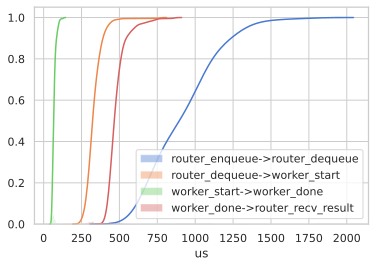

In [9]:
for name, s in diff_df.T.iterrows():
    sns.distplot(s, label=name, kde_kws={"cumulative": True})
plt.legend()
plt.xlabel("us")